Importo los archivos los archivos y tomo las caracteristicas de interes



In [183]:
!pip install arch
!pip install statsmodel

C:\Users\joaco\AppData\Roaming\Python\Python311\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  return process_handler(cmd, _system_body)
C:\Users\joaco\AppData\Roaming\Python\Python311\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)
C:\Users\joaco\AppData\Roaming\Python\Python311\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)
ERROR: Could not find a version that satisfies the requirement statsmodel (from versions: none)
ERROR: No matching distribution found for statsmodel


In [184]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from arch.unitroot import ADF, PhillipsPerron
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter
import scipy

In [185]:
# Open hdf5 files
filename_h1 = 'h1_4khz_32s.hdf5'
filename_l1 = 'l1_4khz_32s.hdf5'

with h5py.File(filename_h1, 'r') as f_h1:
    h1_s = f_h1['strain/Strain'][...]
    h1_fs = 1 / f_h1['strain/Strain'].attrs['Xspacing']
    h1_st = f_h1['meta/GPSstart'][()]

with h5py.File(filename_l1, 'r') as f_l1:
    l1_s = f_l1['strain/Strain'][...]
    l1_fs = 1 / f_l1['strain/Strain'].attrs['Xspacing']
    l1_st = f_l1['meta/GPSstart'][()]

Realizo un EDA

In [186]:
gw_time = 1126259462.442
gw_st = gw_time - h1_st
gw_large = 0.2
time = np.arange(0,h1_s.shape[0]/h1_fs, 1/h1_fs)

In [187]:
gw_st

15.441999912261963

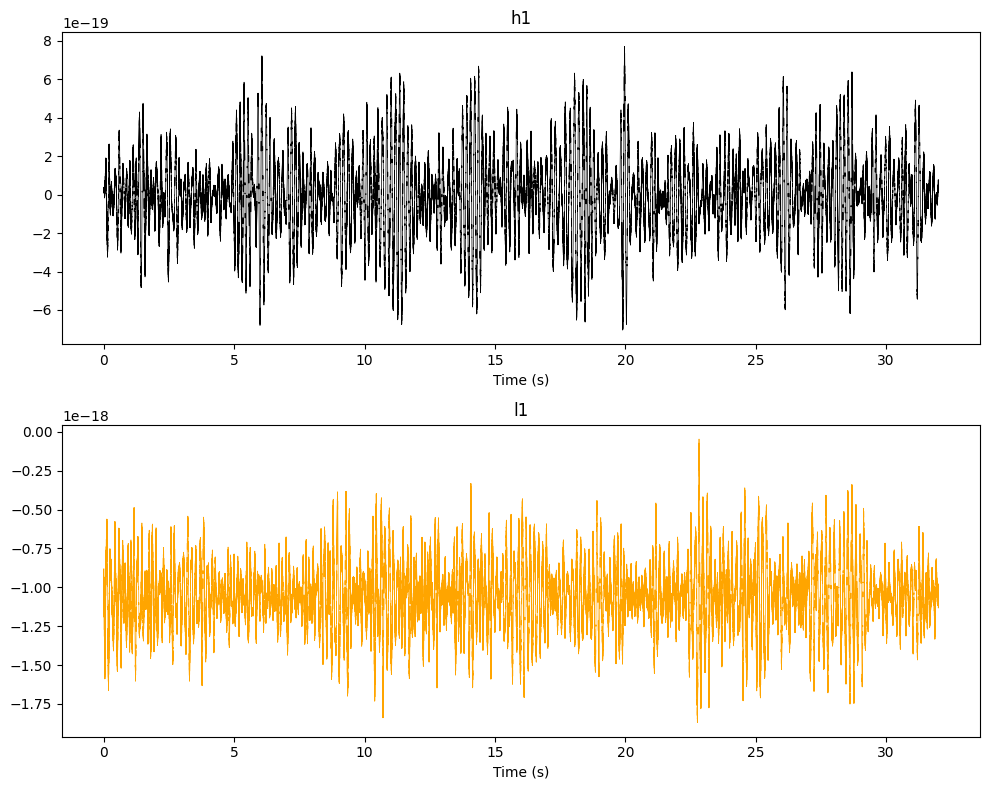

In [188]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(time, h1_s, linewidth=0.5, color= "black")
ax1.set_title('h1')
ax1.set_xlabel('Time (s)')

ax2.plot(time, l1_s, linewidth=0.5, color= "orange")
ax2.set_title('l1')
ax2.set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

Separo una porcion del espectro con el evento y analizo despues el ruido por separado

In [189]:
N = 1

#seccion con evento +-1s
h1_gw = h1_s[(time >= gw_st-N) & (time <= gw_st + N)]
l1_gw = l1_s[(time >= gw_st-N) & (time <= gw_st + N)]
time_gw = time[(time >= gw_st-N) & (time <= gw_st + N)]

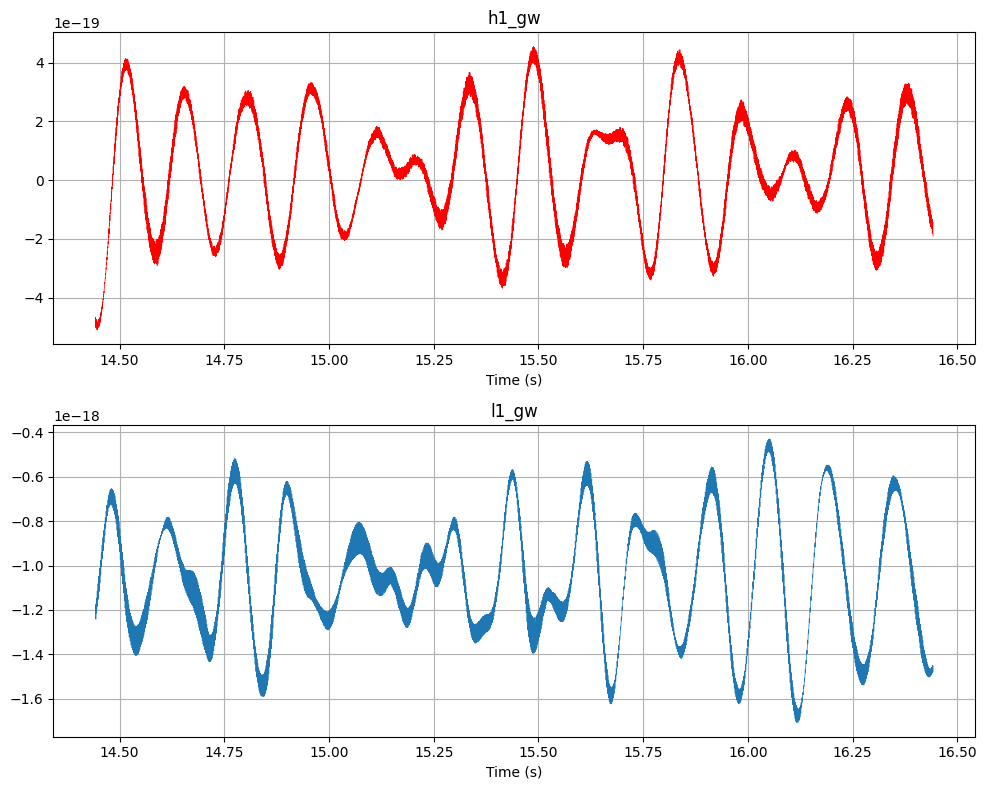

In [190]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(time_gw, h1_gw, linewidth=0.5, color= "red")
ax1.grid()
ax1.set_title('h1_gw')
ax1.set_xlabel('Time (s)')
ax2.plot(time_gw, l1_gw, linewidth=0.5)
ax2.set_title('l1_gw')
ax2.set_xlabel('Time (s)')

plt.tight_layout()
ax2.grid()
plt.show()

Ahora separo el ruido para estudiar estacionareidad

In [191]:
#ruido cola derecha

h1_ruido = h1_s[(time > gw_st + N)]
l1_ruido = l1_s[(time > gw_st + N)]
time_ruido = time[(time > gw_st + N)]

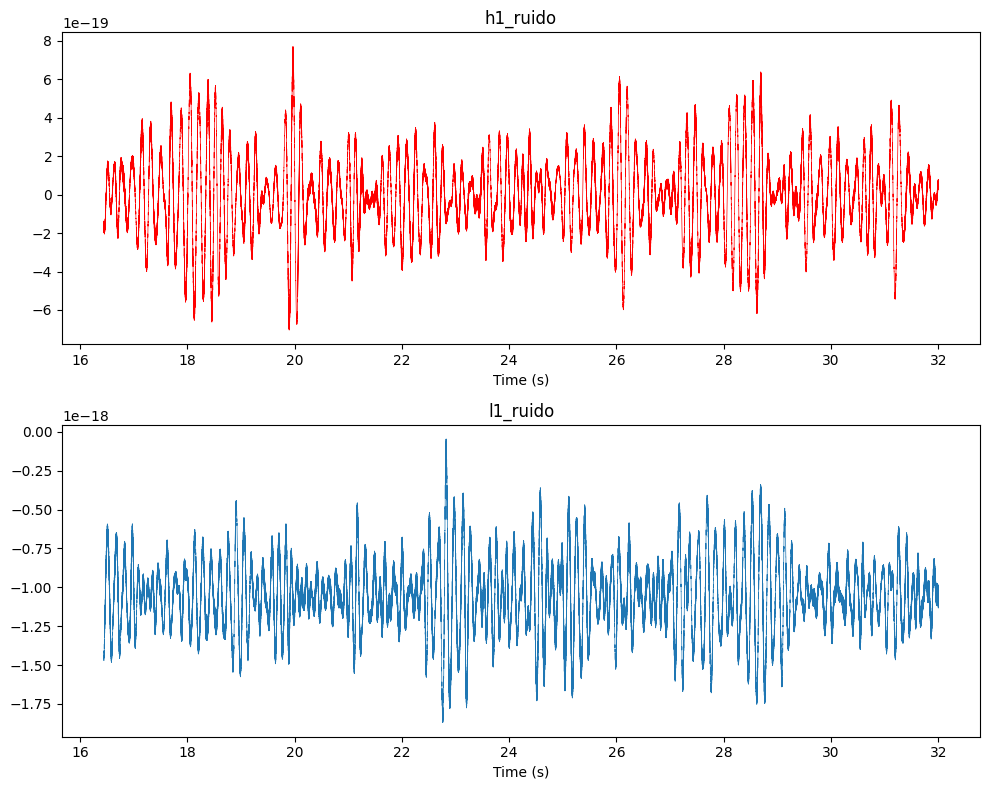

In [192]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(time_ruido, h1_ruido, linewidth=0.5, color= "red")
ax1.set_title('h1_ruido')
ax1.set_xlabel('Time (s)')

ax2.plot(time_ruido, l1_ruido, linewidth=0.5)
ax2.set_title('l1_ruido')
ax2.set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

TEST DE ESTACIONAREIDAD

Se multiplica por una constante grande, ya que debido a los valores de la señal hace underflow en algunos casos dando resultados erroneos

In [193]:
def EsEstacionario(signal, alpha):
  #PhillipsPerron Test
  phpr_result = PhillipsPerron(signal)
  phpr_p_value = phpr_result.pvalue
  phpr_test_result = "Stationary" if phpr_p_value < alpha else "Not stationary"
  print("Augmented Dickey-Fuller Test:", phpr_test_result)
  # Augmented Dickey-Fuller Test
  adf_result = ADF(signal)
  adf_p_value = adf_result.pvalue #adf_result[1]
  adf_test_result = "Stationary" if adf_p_value < alpha else "Not stationary"
  print("Augmented Dickey-Fuller Test:", adf_test_result)
  # Kwiatkowski-Phillips-Schmidt-Shin Test
  kpss_result = kpss(signal)
  kpss_p_value = kpss_result[1]
  kpss_test_result = "Stationary" if kpss_p_value > alpha else "Not stationary"
  print("Kwiatkowski-Phillips-Schmidt-Shin Test:", kpss_test_result)

In [194]:
#Valor significativo: 
alpha = 0.05

#95% de confianza

import warnings
warnings.filterwarnings('default')
warnings.simplefilter('default')

In [195]:
EsEstacionario(l1_ruido/np.max(abs(l1_ruido)), alpha)

c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:1125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:1133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]


Augmented Dickey-Fuller Test: Stationary
Augmented Dickey-Fuller Test: Stationary
Kwiatkowski-Phillips-Schmidt-Shin Test: Stationary


c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:776: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]
C:\Users\joaco\AppData\Local\Temp\ipykernel_4448\511359593.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(signal)


In [196]:
EsEstacionario(h1_ruido/np.max(abs(h1_ruido)), alpha)

c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:1125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:1133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]


Augmented Dickey-Fuller Test: Stationary
Augmented Dickey-Fuller Test: Stationary
Kwiatkowski-Phillips-Schmidt-Shin Test: Stationary


c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:776: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]
C:\Users\joaco\AppData\Local\Temp\ipykernel_4448\511359593.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(signal)


Da estacionario, restamos entonces las medias a cada señal.

In [197]:
h1_ruido = h1_ruido - np.mean(h1_ruido)
l1_ruido = l1_ruido - np.mean(l1_ruido)

Periodograma

In [294]:
def periodogram(x, win):
    N = len(x)
    w = scipy.signal.get_window(Nx = N, window = win)
    X = scipy.fft.fft(x*w)
    Rx = X*np.conj(X)/N
    return Rx

def autocorr(x):
    return scipy.signal.correlate(x,x, 'full')/len(x)

def manualautocorr(x, L):
    #L es el lag máximo que quiero computar
    N = len(x)
    rx = np.zeros(N)
    for l in range(L):
        sum = 0
        for i in range(N-l):
            sum += (x[i]*x[i+l])/N
        rx[l]=sum
    rx2 = (rx[1:])[::-1]
    return np.concatenate([rx2, rx])

A modo de analisis exploratorio de los datos graficamos el estimador de autocorrelación d elas señales para diferentes lags. 


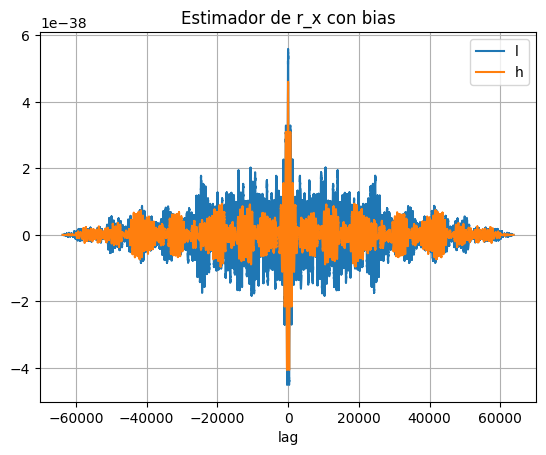

In [235]:
rx_l1 = autocorr(l1_ruido)
rx_h1 = autocorr(h1_ruido)

x_axis = np.array(range(len(rx_h1)))
x_axis = x_axis-len(x_axis)/2-1
plt.plot(x_axis,rx_l1, label = 'l')
plt.plot(x_axis,rx_h1, label = 'h')

plt.xlabel('lag')
plt.legend()
plt.grid()
plt.title('Estimador de r_x con bias')
plt.show()

Luego realizamos un periodograma clásico (es decir, ventaneando los datos con una ventana rectangular). Elegimos tomar la totalidad de los datos para que el valor esperado del periodograma tienda al valor del periodograma. Sin embargo obseramos dos problemas conocidos, primero el periodograma aproximado por el ventaneo de la señal no refleja el espectrograma real. Por otro lado, el mismo tiene un alto grado de leakege espectral. 

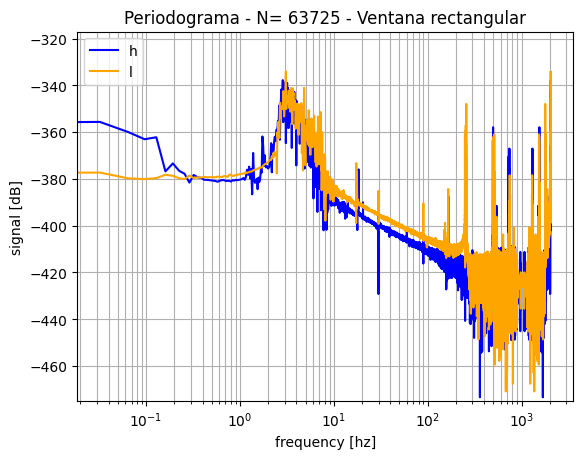

In [295]:
Rx_h = periodogram(h1_ruido, 'boxcar')
Rx_l = periodogram(l1_ruido, 'boxcar')
x_ax = np.linspace(0,0.5, len(Rx)) * h1_fs
plt.plot(x_ax, 10*np.log10(abs(Rx_h)), 'blue', label = 'h')
plt.plot(x_ax, 10*np.log10(abs(Rx_l)), 'orange', label = 'l')
plt.title('Periodograma - N= ' + str(len(h1_ruido)) + ' - Ventana rectangular')
plt.grid(True, which= 'both')
plt.xscale("log")
plt.ylim(-475)
plt.ylabel('signal [dB]')
plt.xlabel('frequency [hz]')
plt.legend()
plt.show()

Observando que realizar un periodograma modificado con otra ventana mejora el leakeage espectral, pero no resuelve el problema fundamental del periodograma, que es su varianza que no baja al aumentar N. Observando esto, en lso siguientes procedimientos simepre ventanearemos los datos en el tiempo utilizando una ventana de Parzen para mejorar el leakeage espectral. 

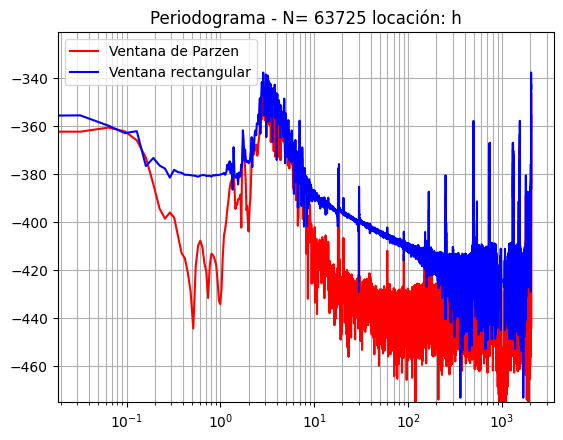

In [319]:
Rx2 = periodogram(h1_ruido, 'parzen')
x_ax = np.linspace(0,0.5, len(Rx)) * h1_fs
plt.plot(x_ax, 10*np.log10(abs(Rx2)), 'red', label = 'Ventana de Parzen')
Rx = periodogram(h1_ruido, 'boxcar')
plt.plot(x_ax, 10*np.log10(abs(Rx)), 'blue', label = 'Ventana rectangular')
plt.title('Periodograma - N= ' + str(len(h1_ruido))+ ' locación: h')
plt.grid(True, which= 'both')
plt.xscale("log")
plt.ylim(-475)
plt.legend()
plt.show()

Periodogram smoothing (Blackman-Tuckey)

Lo visto en el punto anterior nos lleva a considerar las alternativas para reducir estos problemas. La primera de estas es el enfoque de suavizado del periodograma (periodogram smoothing, o también llamado algoritmo de blackman-tuckey). A continuación se implementa el mismo, de acuerdo a la información brindada por la bibliografía sugerida por la cátedra. 

In [289]:

def apply_window(rx, L, win):
    N = len(rx)
    window = scipy.signal.get_window(Nx = 2*L-1, window = win)
    pad_width = int((N-len(window))/2)
    padded_window = np.pad(array = window, pad_width=pad_width)
    return rx*padded_window


def blackman_tuckey(signal, L, w):
    rx = autocorr(signal)
    N = len(signal)
    Rx_smoothing = abs(scipy.fft.fft(apply_window(rx, L, w)))
    return Rx_smoothing[:len(signal)]

En cuanto a la elecccion de las variables apra la aplicación de esta técnica, decidimos utilizar una ventana de Parzen ya que evita problemas con la positividsad de Rx y, además, produce mejores resultados en cuanto a leakeage espectral que la ventana de Bartlett, que sería la alternativa. 
* Luego, N y L tienen que ser grandes para que el valor esperado de la estimación sea el del periodograma ideal, 
* sin embargo esto presenta un trade-off con la varianza, que disminuye de manera inversamente proporcional a L (y proporcionalmente a N)

Por esto, decidimos nuevamente utilizar un N lo mayor posible para conseguir balancear por un lado la necisad de resolución y reducir el bias, y por otro lograr un buen smoothing del periodograma. Luego, siguiendo la regla de oro de que L<=N/4 propuesta por Box and Jenkins (1976) decidimos que L = N/8 para que el mismo siga siendo alto (que el bias no crezca) y produzca al mismo tiempo.

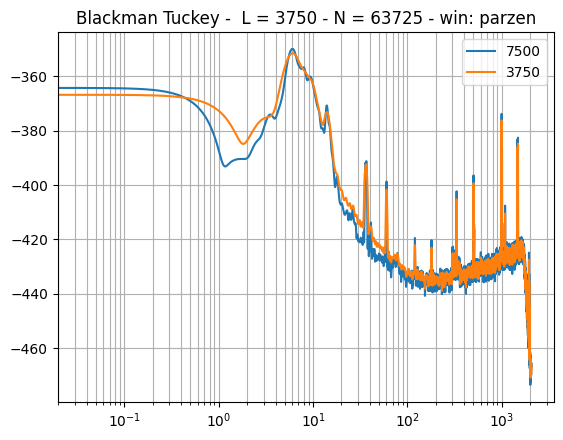

In [310]:


w = 'parzen'

N = 60000
L = int(N/8)

sig = h1_ruido[:N]*scipy.signal.get_window(window = 'parzen', Nx = 60000)

smoothRx = blackman_tuckey(sig, L, w)
x_ax = np.linspace(0,0.5, len(smoothRx)) * h1_fs
plt.plot(x_ax, 10*np.log10(smoothRx), label = str(L))

N = 60000
L = int(N/16)

w = 'parzen'
smoothRx = blackman_tuckey(sig, L, w)
x_ax = np.linspace(0,0.5, len(smoothRx)) * h1_fs

plt.plot(x_ax, 10*np.log10(smoothRx), label = str(L))
plt.title('Blackman Tuckey -  L = ' + str(L) + ' - N = ' + str(len(h1_ruido)) + ' - win: ' + w)
plt.grid(True, which='both')
plt.xscale("log")
plt.legend()

plt.show()

Finalmente, probamos otra técnica para suavizar el periodograma, el promediado (también llamado algoritmo de Welch-Bartlett). Esta consta de la subdivisión de las muestras tomadas en el tiempo en diferentes secciones, opcionalmente ocn cierto overlap. A continuación planteamos las funciones necesarias para hacer lo propuesto. Hay que notar que en nuestra función K (la contidad de segmentos promediados) no se selecciona directamente, sino indirectamente a través del tamaño de los segmentos y el overlap deseado. 

In [290]:
def welch_bartlett(signal, w, segment_size, overlap = 0):

    X_prom = np.zeros(segment_size)
    N = len(signal)
    i=0
    segment_count = 0
    d = int(segment_size*(1-overlap))
    while i+segment_size<N:
        segment = signal[i:i+segment_size]
        s_len = len(segment)
        Xr = abs(scipy.fft.fft(segment*scipy.signal.get_window(Nx = s_len, window = w)))
        X_prom += np.power(Xr, 2)
        i=i+d
        segment_count+=1


    X_prom /= (segment_count*segment_size)

    return X_prom[:int(segment_size/2)]

Luego, procedemos a realizar una estimación de Rx con esta técnica. Como en el caso anterior, utilizamos segmentos lo más largos posible para poder disminuir en mayor medida la varianza. Ya que un mayor N permite aumentar el K sin perder tanta resolución. Además se optó por un overlap del 50% para poder disminuir la varianza del estimador en un factor de  1/2K en lugar de 1/K. Además, se probaron difderentes tamaños de segmentos. En definitiva elegimos N/16 ya que provee un buen balance entre resolución y disminucion de varianza.   

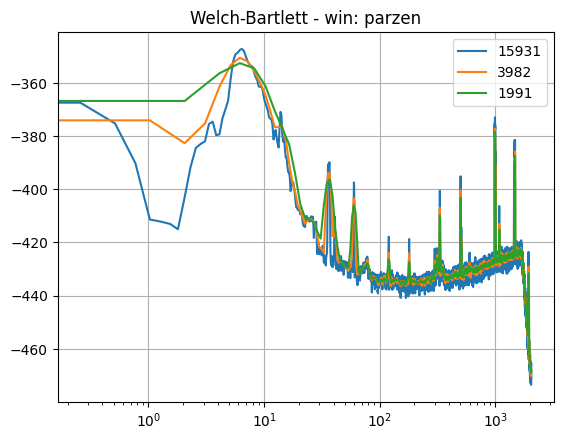

In [316]:
w = 'parzen'

L = int(len(h1_ruido)/4)
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.5)
x_ax = np.linspace(0,0.5, len(Rx_pa)) * h1_fs
plt.plot(x_ax,10*np.log10(Rx_pa), label = L)
plt.title('Welch-Bartlett - win: ' + w)
#plt.grid()
#plt.xscale("log")

w = 'parzen'
L = int(len(h1_ruido)/16)
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.5)
x_ax = np.linspace(0,0.5, len(Rx_pa)) * h1_fs
plt.plot(x_ax,10*np.log10(Rx_pa), label = L)
#plt.title('Welch-Bartlett - win: ' + w)
#plt.grid()
#plt.xscale("log")

w = 'parzen'
L = int(len(h1_ruido)/32)
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.5)
x_ax = np.linspace(0,0.5, len(Rx_pa)) * h1_fs
plt.plot(x_ax, 10*np.log10(Rx_pa), label = L)
#plt.title('Welch-Bartlett - win: ' + w)
plt.grid()
plt.xscale("log")
plt.legend()
plt.show()

whitenning

hay que tomar el mejor metodo, y definir h1p_f a la frecuencia y h1p_p al espectro

De los metodos analizado la solución que más nos convenció fue el promediado de periodogramas ya que permitió disminuir la varianza en mayor medida utilizando la misma cantidad de datos y sin perder resolución en las zonas de frecuencia relevantes al proceso. Según el análisis que realizamos el overlap marca la diferencia entre las dos técnicas. 

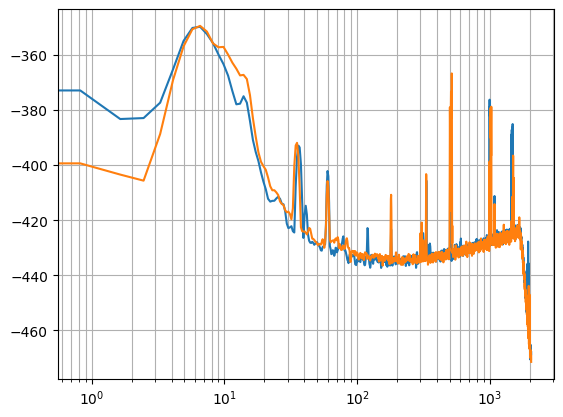

In [205]:
w = 'parzen'
L = 5000
h1p_p =  welch_bartlett(h1_ruido, w, L, overlap=0.5)
h1p_f = np.linspace(0,0.5, len(Rx_whitenning_h1)) * h1_fs
plt.plot(h1p_f, 10*np.log10(Rx_whitenning_h1), label = str(L))


w = 'parzen'
L = 5000
l1p_p =  welch_bartlett(l1_ruido, w, L, overlap=0.5)
l1p_f = np.linspace(0,0.5, len(Rx_whitenning_l1)) * h1_fs
plt.plot(h1p_f, 10*np.log10(Rx_whitenning_l1), label = str(L))

plt.xscale("log")
plt.grid(True, which="both")

In [206]:
print(h1p_f.shape)
print(h1p_p.shape)

h1_psd = interp1d(h1p_f, h1p_p, kind='nearest', bounds_error=False, assume_sorted=True)
l1_psd = interp1d(l1p_f, l1p_p, kind='nearest', bounds_error=False, assume_sorted=True)

(2500,)
(2500,)


In [207]:

h1_psd = np.abs(h1_psd(np.fft.rfftfreq(len(h1_s), 1/h1_fs)))**2
l1_psd = np.abs(l1_psd(np.fft.rfftfreq(len(l1_s), 1/l1_fs)))**2

# Signal whitening
h1_w = np.fft.irfft(np.fft.rfft(h1_s) / np.sqrt(h1_psd))
l1_w = np.fft.irfft(np.fft.rfft(l1_s) / np.sqrt(l1_psd))

In [208]:
nyqh = 0.5 * h1_fs
low_h = 30
high_h = 300
lowh = low_h / nyqh
highh = high_h / nyqh
bh, ah = butter(6, [lowh, highh], btype='band')

nyql = 0.5 * l1_fs
low_l = 20
high_l = 300
lowl = low_l / nyql
highl = high_l / nyql
bl, al = butter(6, [lowl, highl], btype='band')

# Apply passband filter
h1_f_w = lfilter(bh, ah, h1_w)
l1_f_w = lfilter(bl, al, l1_w)

In [209]:
import scipy.io.wavfile
wav_interval = (time > gw_st - 2) & (time < gw_st + 2)
#Scale signal to fit WAV format
h1_gw_fin = np.int16(h1_f_w[wav_interval]/np.max(np.abs(h1_f_w[wav_interval])) * 32767 * 0.9)
l1_gw_fin = np.int16(l1_f_w[wav_interval]/np.max(np.abs(l1_f_w[wav_interval])) * 32767 * 0.9)
scipy.io.wavfile.write('h1_gw.wav', int(h1_fs), h1_gw_fin)
scipy.io.wavfile.write('l1_gw.wav', int(l1_fs), l1_gw_fin)

In [220]:
from IPython.display import Audio
from pydub import AudioSegment


audio = AudioSegment.from_file("h1_gw.wav", format="wav")
upshift = 4 
shifted_audio = audio.speedup(playback_speed=(2**(upshift/12.0)))
shifted_audio.export("h1_gw_upshifted.wav", format="wav")
audio_file = "h1_gw_upshifted.wav"t
audio = Audio(audio_file)


display(audio)

C:\Users\joaco\AppData\Local\Temp\ipykernel_4448\647700888.py:5: ResourceWarning: unclosed file <_io.BufferedReader name='h1_gw.wav'>
  audio = AudioSegment.from_file("h1_gw.wav", format="wav")
C:\Users\joaco\AppData\Local\Temp\ipykernel_4448\647700888.py:14: ResourceWarning: unclosed file <_io.BufferedRandom name='h1_gw_upshifted.wav'>
  shifted_audio.export("h1_gw_upshifted.wav", format="wav")


In [211]:

audio = AudioSegment.from_file("l1_gw.wav", format="wav")

upshift = 4 
shifted_audio = audio.speedup(playback_speed=(2**(upshift/12.0)))
shifted_audio.export("l1_gw_upshifted.wav", format="wav")
audio_file = "l1_gw_upshifted.wav"
audio_file = "l1_gw.wav"
audio = Audio(audio_file)
display(audio)

C:\Users\joaco\AppData\Local\Temp\ipykernel_4448\1382978914.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='l1_gw.wav'>
  audio = AudioSegment.from_file("l1_gw.wav", format="wav")
C:\Users\joaco\AppData\Local\Temp\ipykernel_4448\1382978914.py:11: ResourceWarning: unclosed file <_io.BufferedRandom name='l1_gw_upshifted.wav'>
  shifted_audio.export("l1_gw_upshifted.wav", format="wav")


corr cruzada
habia que invertir uno noma

In [212]:
interval = (time > gw_st - 0.1) & (time < gw_st + 0.1)
N = len(h1_f_w[interval])
x_corr = scipy.correlate(h1_f_w[interval], -l1_f_w[interval], 'full')

C:\Users\joaco\AppData\Local\Temp\ipykernel_4448\2712613451.py:3: DeprecationWarning: scipy.correlate is deprecated and will be removed in SciPy 2.0.0, use numpy.correlate instead
  x_corr = scipy.correlate(h1_f_w[interval], -l1_f_w[interval], 'full')


In [213]:
deltaT = (np.argmax(x_corr)-N)/h1_fs * 1e3

In [214]:
360*np.arccos(deltaT/10)/(2*np.pi)

46.87488633081353